In [1]:
!git clone https://github.com/ziatdinovmax/im2spec.git
%cd im2spec

Cloning into 'im2spec'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 57 (delta 24), reused 23 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (57/57), 1.87 MiB | 7.12 MiB/s, done.
Resolving deltas: 100% (24/24), done.
/Users/adivatsavai/Downloads/test/im2spec


In [2]:
import gc
import pyUSID as usid

In [3]:
import gym
from gym import spaces
import numpy as np
#import pygame



import scipy
import h5py
import matplotlib.pyplot as plt
#import pyUSID as usid
import sidpy as sid

import os
from copy import deepcopy as dc

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
#from torch_kmeans import KMeans

from im2spec.models import conv_block, dilated_block
from im2spec.utils import create_training_set, predict, encode, decode
from im2spec.train_utils import trainer

import random
from collections import namedtuple, deque
from typing import List, Tuple
import math

In [4]:
def feature_extractor(model, X):
    return(model.encoder(torch.tensor(X).reshape(X.shape[0], 1, image_patch, image_patch)))

In [5]:
def get_image_patch(image, pos, image_patch):
    return(image[pos[0]-int((image_patch-1)/2): pos[0] + int((image_patch+1)/2), pos[1]-int((image_patch-1)/2): pos[1] + int((image_patch+1)/2)])

In [6]:
def err_train(model, X, reward, criterion, optimizer, autoencoder):
    data = feature_extractor(autoencoder, np.array(X)).float().to(device = device)
    #data = data.reshape([data.shape[0], 1, data.shape[1]])
    targets = torch.tensor(reward).float().to(device = device)

    scores = model.forward(data)

    loss = criterion(scores, targets.reshape(targets.shape[0], 1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [7]:
def model_train(model, X, y, criterion, optimizer):
    model.train()
    scores = model(torch.tensor(X).to(device).reshape([X.shape[0], 1, X.shape[1], X.shape[2]]))
    targets = torch.tensor(np.array(y)).to(device)
    loss = criterion(scores, targets.reshape([targets.shape[0], 1, targets.shape[1]]))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model.eval()

In [8]:
class im2spec(nn.Module):
    """
    Encoder (2D) - decoder (1D) type model for generating spectra from image
    """
    def __init__(self,
                 feature_size: Tuple[int, int],
                 target_size: int,
                 latent_dim: int,
                 nb_filters_enc: int = 64,
                 nb_filters_dec: int = 64) -> None:
        super(im2spec, self).__init__()
        self.n, self.m = feature_size
        self.ts = target_size
        self.e_filt = nb_filters_enc
        self.d_filt = nb_filters_dec
        # Encoder params
        self.enc_conv = conv_block(
            ndim=2, nb_layers=3,
            input_channels=1, output_channels=self.e_filt,
            lrelu_a=0.1, use_batchnorm=True, dropout_ = 0.5)
        self.enc_fc = nn.Linear(self.e_filt * self.n * self.m, latent_dim)
        # Decoder params
        
        self.dec_fc1 = nn.Linear(latent_dim, self.ts //4 )
        self.dec_fc2 = nn.Linear(self.ts // 4, self.ts //4 * 2 )
        self.dec_fc3 = nn.Linear(self.ts //4 * 2, self.ts //4 * 3 )
        self.dec_fc4 = nn.Linear(self.ts //4 * 3, self.ts)
        self.dec_fc5 = nn.Linear(self.ts, self.ts)
        self.dec_fc6 = nn.Linear(self.ts, self.ts)
        
        self.dec_fc = nn.Linear(latent_dim, self.d_filt*self.ts)
        self.dec_atrous = dilated_block(
            ndim=1, input_channels=self.d_filt, output_channels=self.d_filt,
            dilation_values=[1, 2, 3, 4], padding_values=[1, 2, 3, 4],
            lrelu_a=0.1, use_batchnorm=True)
        self.dec_conv = conv_block(
            ndim=1, nb_layers=1,
            input_channels=self.d_filt, output_channels=1,
            lrelu_a=0.1, use_batchnorm=True)
        self.dec_out = nn.Conv1d(1, 1, 1)
        '''
        self.dec_fc = nn.Linear(latent_dim, self.d_filt*self.ts)
        self.dec_atrous = dilated_block(
            ndim=1, input_channels=self.d_filt, output_channels=self.d_filt,
            dilation_values=[1, 2, 3, 4], padding_values=[1, 2, 3, 4],
            lrelu_a=0.1, use_batchnorm=True)
        self.dec_conv = conv_block(
            ndim=1, nb_layers=1,
            input_channels=self.d_filt, output_channels=1,
            lrelu_a=0.1, use_batchnorm=True)
        self.dec_out = nn.Conv1d(1, 1, 1)
        '''
    def encoder(self, features: torch.Tensor) -> torch.Tensor:
        """
        The encoder embeddes the input image into a latent vector
        """
        x = self.enc_conv(features)
        x = x.reshape(-1, self.e_filt * self.m * self.n)
        return self.enc_fc(x)

    def decoder(self, encoded: torch.Tensor) -> torch.Tensor:
        """
        The decoder generates 1D signal from the embedded features
        """
        
        x = F.relu(self.dec_fc1(encoded))
        x = F.relu(self.dec_fc2(x))
        x = F.relu(self.dec_fc3(x))
        x = F.relu(self.dec_fc4(x))
        x = F.relu(self.dec_fc5(x))
        
        return self.dec_fc6(x).reshape(-1, 1, self.ts)
        '''
        x = self.dec_fc(encoded)
        x = x.reshape(-1, self.d_filt, self.ts)
        x = self.dec_atrous(x)
        x = self.dec_conv(x)
        return self.dec_out(x)
        '''
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward model"""
        encoded = self.encoder(x)
        return self.decoder(encoded)


In [9]:
class im2im(nn.Module):
    def __init__(self,
                 feature_size: Tuple[int, int],
                 latent_dim: int = 10,
                 nb_filters_enc: int = 64,
                 nb_filters_dec: int = 64) -> None:
        super(im2im, self).__init__()
        self.n, self.m = feature_size
        self.e_filt = nb_filters_enc
        self.d_filt = nb_filters_dec
        # Encoder params
        self.enc_conv = conv_block(
            ndim=2, nb_layers=3,
            input_channels=1, output_channels=self.e_filt,
            lrelu_a=0.1, use_batchnorm=True)
        self.enc_fc = nn.Linear(self.e_filt * self.n * self.m, latent_dim)
        # Decoder params
        self.dec_fc = nn.Linear(latent_dim, self.d_filt * (self.n//4) * (self.n//4))
        self.dec_conv_1 = conv_block(
            ndim=2, nb_layers=1,
            input_channels=self.d_filt, output_channels=self.d_filt,
            lrelu_a=0.1, use_batchnorm=True)
        self.dec_conv_2 = conv_block(
            ndim=2, nb_layers=1,
            input_channels=self.d_filt, output_channels=self.d_filt,
            lrelu_a=0.1, use_batchnorm=True)
        self.dec_atrous = dilated_block(
            ndim=2, input_channels=self.d_filt, output_channels=self.d_filt,
            dilation_values=[1, 2, 3, 4], padding_values=[1, 2, 3, 4],
            lrelu_a=0.1, use_batchnorm=True)
        self.dec_conv_3 = conv_block(
            ndim=2, nb_layers=1,
            input_channels=self.d_filt, output_channels=1,
            lrelu_a=0.1, use_batchnorm=True)
        self.dec_out = nn.Conv2d(1, 1, 1)
    
    def encoder(self, features: torch.Tensor) -> torch.Tensor:
        """
        The encoder embeddes the input image into a latent vector
        """
        x = self.enc_conv(features)
        x = x.reshape(-1, self.e_filt * self.m * self.n)
        return self.enc_fc(x)
    
    def decoder(self, encoded: torch.Tensor) -> torch.Tensor:
        """
        The decoder generates 2D image from the embedded features
        """
        x = self.dec_fc(encoded)
        x = x.reshape(-1, self.d_filt, self.n//4, self.n//4)
        x = self.dec_conv_1(x)
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        x = self.dec_conv_2(x)
        x = F.interpolate(x, scale_factor=self.n/(2 * (self.n//4)), mode="nearest")
        x = self.dec_atrous(x)
        x = self.dec_conv_3(x)

        return self.dec_out(x)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward model"""
        encoded = self.encoder(x)
        return self.decoder(encoded)

    
        
    

In [10]:
def find_max_in_keys(dictionary):
    max_first = float('-inf')  # Initialize to negative infinity to handle all positive numbers
    max_second = float('-inf')
    
    for key in dictionary.keys():
        try:
            first, second = map(int, key.split(':'))  # Split key by ':' and convert to integers
            if first > max_first:
                max_first = first
            if second > max_second:
                max_second = second
        except:
            pass
    
    return max_first, max_second

In [11]:
#download and read ground truth data
!gdown https://drive.google.com/uc?id=16toh0W0qS4BgMh9y2PJBqFIXRocJNK5H

h5_f = h5py.File(r'PTO_SSPFM.h5', 'r+')
my_dict = h5_f['ForceMap']
max_rows, max_cols = find_max_in_keys(my_dict)

dset = h5_f['ForceMap']['0:0']
dc_bias_all = dset[5,:]
good_inds = np.where(~np.isnan(dc_bias_all))[0]
first_index = good_inds[0]
last_index = good_inds[-1]
dc_vec_OF_IF = dc_bias_all[first_index:last_index]
dc_vec = dc_vec_OF_IF[20::10][::2]

#Make the amp, phase matrices
amp_OF = np.zeros(shape=(max_rows, max_cols, len(dc_vec)))
amp_IF = np.zeros(shape=(max_rows, max_cols, len(dc_vec)))
phase_OF = np.zeros(shape=(max_rows, max_cols, len(dc_vec)))
phase_IF = np.zeros(shape=(max_rows, max_cols, len(dc_vec)))

for row in range(max_rows):
    for col in range(max_cols):
        
        dset = h5_f['ForceMap'][str(row) + ':' + str(col)]
        
        amp_resp_all = dset[2,first_index:last_index]
        phase_resp_all = dset[3,first_index:last_index]
        floor_ind = np.floor(len(amp_resp_all)/10)*10
        
        amp_resp_reshaped = amp_resp_all[:int(floor_ind)].reshape(-1,10)
        amp_resp_mean = amp_resp_reshaped.mean(axis=1)
        amp_resp_OF = amp_resp_mean[::2]
        amp_resp_IF = amp_resp_mean[1::2]

        phase_resp_reshaped = phase_resp_all[:int(floor_ind)].reshape(-1,10)
        phase_resp_mean = phase_resp_reshaped.mean(axis=1)
        phase_resp_OF = phase_resp_mean[::2]
        phase_resp_IF = phase_resp_mean[1::2]

        amp_OF[row,col,:] = amp_resp_OF
        amp_IF[row,col,:] = amp_resp_IF
        phase_OF[row,col,:] = phase_resp_OF
        phase_IF[row,col,:] = phase_resp_IF


Downloading...
From (original): https://drive.google.com/uc?id=16toh0W0qS4BgMh9y2PJBqFIXRocJNK5H
From (redirected): https://drive.google.com/uc?id=16toh0W0qS4BgMh9y2PJBqFIXRocJNK5H&confirm=t&uuid=890387d2-2609-4317-b91c-e2f8b613a7df
To: /Users/adivatsavai/Downloads/test/im2spec/PTO_SSPFM.h5
100%|████████████████████████████████████████| 249M/249M [00:05<00:00, 46.7MB/s]


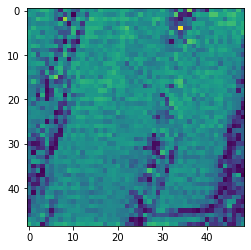

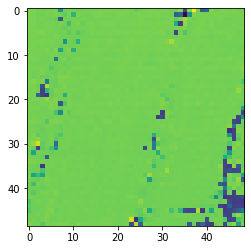

In [16]:
#amplitude and phase images

plt.figure()
plt.imshow(amp_OF[:,:,25])

plt.figure()
plt.imshow(phase_OF[:,:,25])

In [17]:
pola = amp_OF*np.cos(phase_OF*np.pi/180)
norm_pola = 2/(pola.max() - pola.min()) * pola - 2/(pola.max() - pola.min()) * pola.min() - 1
norm_pola = np.array(norm_pola, dtype = np.float32)

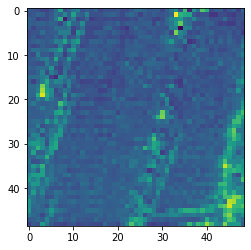

In [18]:
#polarization image

plt.imshow(pola[:,:, 25])

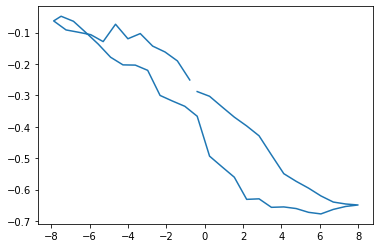

In [19]:
#example hysteresis loop

plt.plot(dc_vec[49:], norm_pola[0, 25, 49:])

In [20]:
#define gym environment

class environment(gym.Env):
    def __init__(self, image, spectra, start = [50, 50], image_patch = 5, image_size = 100, y_dim = 64):
        super(environment, self).__init__()
        self.num_not_measure = 0
        self.num_measure = 0
        self.image_patch = image_patch
        self.image_size = image_size
        self.radius = int((image_patch - 1)/2)+1
        self.image = image
        self.spectra = spectra
        self.y_dim = y_dim
        #self.color = 255/(image.max() - image.min()) * image - 255/(image.max() - image.min()) * image.min()
        self.num_rows = image_size
        self.num_columns = image_size
        self.all_X = []
        self.X = []
        self.y = []
        self.all_X.append(get_image_patch(self.image, start, self.image_patch))
        self.X.append((get_image_patch(self.image, start, self.image_patch)))
        self.y.append(spectra[start[0], start[1]])
        self.seen = np.zeros([self.image_size, self.image_size])
        self.pos_X = []
        self.pos_X.append(start)
        self.pos = [start[0], start[1]]
        self.measured = np.zeros([self.image_size, self.image_size])
        self.display = np.zeros([self.image_size, self.image_size])
        self.measured[start[0], start[1]] = 1
        
        for i in range(self.radius):
                for j in range(self.radius):
                    self.seen[start[0]+i, start[1]+j] = 1
                    self.seen[start[0]-i, start[1]+j] = 1
                    self.seen[start[0]+i, start[1]-j] = 1
                    self.seen[start[0]-i, start[1]-j] = 1
        
        
        self.observation_space = spaces.Tuple((spaces.Discrete(self.num_rows), spaces.Discrete(self.num_columns)))
        
        #pygame.init()
        #self.cell_size = 8
        #self.screen = pygame.display.set_mode((self.num_columns * self.cell_size, self.num_rows * self.cell_size))
    
    def update_pos(self):
        self.pos[0] = random.randint(self.radius-1, self.image_size - self.radius)
        self.pos[1] = random.randint(self.radius-1, self.image_size - self.radius)
        while self.measured[self.pos[0], self.pos[1]] == 1:
            self.pos[0] = random.randint(self.radius-1, self.image_size - self.radius)
            self.pos[1] = random.randint(self.radius-1, self.image_size - self.radius)
            
        self.all_X.append(get_image_patch(self.image, self.pos, self.image_patch))
    
    def step(self, action, display, num_epochs = 10):
            
        self.num_measure += 1
        self.pos = action
        ind = action
        self.measured[ind[0], ind[1]] = 1
        if display:
            self.display[ind[0], ind[1]] = 1
        for i in range(self.radius):
            for j in range(self.radius):
                self.seen[ind[0]+i, ind[1]+j] = 1
                self.seen[ind[0]-i, ind[1]+j] = 1
                self.seen[ind[0]+i, ind[1]-j] = 1
                self.seen[ind[0]-i, ind[1]-j] = 1
        self.X.append(get_image_patch(self.image, self.pos, self.image_patch))
        self.y.append(spectra[ind[0], ind[1]])
        
        self.pos_X.append([ind[0], ind[1]])

    
            
        
    
    def state(self):

        state = list(self.all_X[-1].reshape(self.image_patch**2))

        return(state)
    
    #def render(self):

        #self.screen.fill((255, 255, 255)) 
        
        #for row in range(self.num_rows):
            #for col in range(self.num_columns):
                #cell_left = col * self.cell_size
                #cell_top = row * self.cell_size
                
                #pygame.draw.rect(self.screen, (0, 0, self.color[row, col]), (cell_left, cell_top, self.cell_size, self.cell_size))
                
                #if self.display[row, col] == 1:
                    
                    #pygame.draw.rect(self.screen, (255, 0, 0), (cell_left, cell_top, self.cell_size, self.cell_size))
                
                #if [row, col] == self.pos:
                    
                    #pygame.draw.rect(self.screen, (0, 255, 0), (cell_left, cell_top, self.cell_size, self.cell_size))
        
                

        #pygame.display.update()

            
    def reset(self, model, start = [50, 50]):
        self.num_measure = 0
        self.pos_X = [[start[0], start[1]]]
        self.all_X = []
        self.X = []
        self.y = []
        self.all_X.append(get_image_patch(self.image, start, self.image_patch))
        self.X.append((get_image_patch(self.image, start, self.image_patch)))
        self.y.append(spectra[start[0], start[1]])
        self.seen = np.zeros([self.image_size, self.image_size])
        self.pos = start
        self.measured = np.zeros([100, 100])
        self.measured[start[0], start[1]] = 1
        
        for i in range(self.radius):
                for j in range(self.radius):
                    self.seen[start[0]+i, start[1]+j] = 1
                    self.seen[start[0]-i, start[1]+j] = 1
                    self.seen[start[0]+i, start[1]-j] = 1
                    self.seen[start[0]-i, start[1]-j] = 1
        
        
        self.observation_space = spaces.Tuple((spaces.Discrete(self.num_rows), spaces.Discrete(self.num_columns)))

        #pygame.init()
        #self.cell_size = 8
        #self.screen = pygame.display.set_mode((self.num_columns * self.cell_size, self.num_rows * self.cell_size))
    

In [21]:
#error predictor

class rewards_model(nn.Module):

    def __init__(self, n_observations):
        super(rewards_model, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.dropout = nn.Dropout(0.1)
        self.layer2 = nn.Linear(128, 1)
        


    def forward(self, x, dropout = True):
        
        x = F.relu(self.layer1(x))
        if dropout:
            x = self.dropout(x)
        
        return self.layer2(x)


    

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
device

device(type='cpu')

In [202]:
start = [25, 25] #initial measurement location 
initialize = 30 #number of initialization points
num_points = 200 #number of total measurements
image_patch = 9 #image patch size
image_size = 49 #image dimension (image_size x image_size)
y_dim = 50 #spectra dimension
image, spectra = norm_pola[:,:,25], norm_pola[:,:,49:]
ldim_i = 2 #im2spec latent space dimension
ldim_a = 3 #autoencoder latent space dimension 
lbda = 2 #exploration decay rate 
num_trials = 30 #number of trials for histogram

In [188]:
device = torch.device("cpu")

In [189]:
#train autoencoder
radius = int((image_patch - 1)/2)
pos_X = []
X = []
y = []
for i in range(radius, image_size - radius):
    for j in range(radius, image_size - radius):
        pos_X.append([i, j])
        ind = pos_X[-1]
        X.append( get_image_patch(image, ind, image_patch))
        y.append(spectra[ind[0], ind[1]])
X = np.array(X)
y = np.array(y)
X = X.reshape([X.shape[0], 1, image_patch, image_patch])
y = y.reshape([y.shape[0], 1, y_dim])

X_tensor = torch.tensor(X).to(device)
y_tensor = torch.tensor(y).to(device)

autoencoder = im2im((image_patch, image_patch), ldim_a).to(device)
autoencoder = trainer(autoencoder, X, X, X, X, num_epochs=30, savename="im2spec_lv{}".format(10)).run()

Epoch: 1... Training loss: 0.00458... Test loss: 0.00429
Epoch: 2... Training loss: 0.0036... Test loss: 0.0035
Epoch: 3... Training loss: 0.00291... Test loss: 0.00249
Epoch: 4... Training loss: 0.00236... Test loss: 0.00215
Epoch: 5... Training loss: 0.00192... Test loss: 0.00197
Epoch: 6... Training loss: 0.00158... Test loss: 0.00184
Epoch: 7... Training loss: 0.00129... Test loss: 0.00141
Epoch: 8... Training loss: 0.00107... Test loss: 0.00116
Epoch: 9... Training loss: 0.00088... Test loss: 0.00077
Epoch: 10... Training loss: 0.00073... Test loss: 0.00072
Epoch: 11... Training loss: 0.00061... Test loss: 0.00062
Epoch: 12... Training loss: 0.00051... Test loss: 0.00053
Epoch: 13... Training loss: 0.00043... Test loss: 0.00046
Epoch: 14... Training loss: 0.00036... Test loss: 0.00035
Epoch: 15... Training loss: 0.00031... Test loss: 0.00038
Epoch: 16... Training loss: 0.00026... Test loss: 0.00024
Epoch: 17... Training loss: 0.00023... Test loss: 0.00024
Epoch: 18... Training los

In [190]:
autoencoder = trainer(autoencoder, X, X, X, X, num_epochs=10, savename="im2spec_lv{}".format(10)).run()

Epoch: 1... Training loss: 6e-05... Test loss: 6e-05
Epoch: 2... Training loss: 5e-05... Test loss: 5e-05
Epoch: 3... Training loss: 4e-05... Test loss: 4e-05
Epoch: 4... Training loss: 4e-05... Test loss: 4e-05
Epoch: 5... Training loss: 4e-05... Test loss: 4e-05
Epoch: 6... Training loss: 4e-05... Test loss: 4e-05
Epoch: 7... Training loss: 4e-05... Test loss: 4e-05
Epoch: 8... Training loss: 4e-05... Test loss: 4e-05
Epoch: 9... Training loss: 4e-05... Test loss: 4e-05
Epoch: 10... Training loss: 4e-05... Test loss: 4e-05


In [53]:
#features = feature_extractor(autoencoder, np.array(X))
#kmeans = KMeans(n_clusters=initialize)
#result = kmeans(features.reshape([1, features.shape[0], features.shape[1]]))
#centers = np.array(result.centers[0])

In [208]:
#curiosity algorithm 

loss_list = []
max_loss_list = []

#loss_list = list(loss_list)
#max_loss_list = list(max_loss_list)

for k in range(num_trials):

    model = im2spec((image_patch, image_patch), y_dim, latent_dim = ldim_i).to(device)
    model_criterion = torch.nn.MSELoss()
    model_optimizer = optim.AdamW(model.parameters(), lr=0.001)
    model.eval()
    
    error_predictor = rewards_model(ldim_a).to(device)
    err_criterion = torch.nn.MSELoss()
    err_optimizer = optim.Adam(error_predictor.parameters(), lr=0.01)
    env = environment(image, spectra, start = start, image_patch = image_patch, image_size = image_size, y_dim = y_dim)
    featurizer = autoencoder
    im_feat = feature_extractor(featurizer, X)
    im_feat = im_feat.reshape([im_feat.shape[0], 1, im_feat.shape[1]]).to(device)
    action = start
    reward = [0]
    e_list = []
    max_e_list = []
    ep_list = []
    eu_list = []
    dist_reward_list = []
    lat_reward_list = []
    loss = []
    reward_list = []
    for i in range(initialize):
        #p = ((np.array(features.detach()) - centers[i])**2).sum(axis = 1).argmin()
        #action = pos_X[p]
        while env.measured[action[0], action[1]] == 1:
                action[0] = random.randint(radius, image_size - radius -1)
                action[1] = random.randint(radius, image_size - radius -1)
        
        env.step(action, False)

    for i in range(5*initialize):
        model_train(model, np.array(env.X), np.array(env.y), model_criterion, model_optimizer)

        y_pred = np.array(model(X_tensor.to(device)).cpu().detach())
        err = (((y_pred - y)**2).sum(axis = 2)/y_dim).reshape(image_size - 2*radius, image_size - 2*radius)
        print(err.sum())
        loss.append(err.sum())



    pred = model(torch.tensor(np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).to(device)).cpu()
    gt = torch.tensor(np.array(env.y).reshape([len(env.y), 1, y_dim]))
    err_i = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
    for i in range(2):
        model_train(model, np.array(env.X), np.array(env.y), model_criterion, model_optimizer)

    pred = model(torch.tensor(np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).to(device)).cpu()
    err_f = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
    
    reward = (err_i + err_f).detach()

    reward_list.append(reward)
    
    #reward = (err_i - err_f).detach()
    
    #reward = np.exp((err_i + err_f).detach()) - 1 
    #reward = np.exp((err_i - err_f).detach()) - 1 

    reward = reward / reward.mean()
    
    for i in range(2*initialize):
        err_train(error_predictor, np.array(env.X), np.array(reward), err_criterion, err_optimizer, featurizer)

    

    err_mean = np.zeros([image_size - 2*radius, image_size - 2*radius])
    err_std = np.zeros([image_size - 2*radius, image_size - 2*radius])
    dist_reward = np.zeros([image_size, image_size])
    lat_reward = np.zeros([image_size - 2*radius, image_size - 2*radius])

    
    while env.num_measure < num_points:

        if random.randint(1, 10)//10:
            ep_list.append(err_mean)
            eu_list.append(err_std)
            dist_reward_list.append(dist_reward)
            lat_reward_list.append(lat_reward)
            while env.measured[action[0], action[1]] == 1:
                action[0] = random.randint(radius, image_size - radius -1)
                action[1] = random.randint(radius, image_size - radius -1)
        else:
            err_pred_list = []
            for i in range(500):
                err_pred_list.append(np.array(error_predictor(im_feat).reshape(X.shape[0]).detach().cpu()))
            err_pred_list = np.array(err_pred_list)
            err_mean = err_pred_list.mean(axis = 0)
            err_mean = err_mean/err_mean.mean()
            err_std = err_pred_list.std(axis = 0)
            err_std = err_std/err_std.mean()
            ep_list.append(err_mean)
            eu_list.append(err_std)
            for i in range(image_size):
                for j in range(image_size):
                    if [i, j] in env.pos_X:
                        dist_reward[i, j] = 0
                    else:
                        dist_reward[i, j] = (((np.array(env.pos_X) - np.array([i, j]))**2).sum(axis = 1)**-0.5).sum()**-1
            dist_reward = dist_reward/dist_reward.mean()
            dist_reward_list.append(dist_reward)
            
            lat_reward = np.zeros((image_size - 2*radius)**2)
            lat = feature_extractor(model, X).detach().numpy()
            lat_m = feature_extractor(model, np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).detach().numpy()
            for i in range((image_size - 2*radius)**2):
                lat_reward[i] += (((lat_m - lat[i])**2).sum(axis = 1)**-0.5).sum()**-1
            
            lat_reward = lat_reward.reshape(image_size - 2*radius, image_size - 2*radius)
            lat_reward = lat_reward/lat_reward.mean()
            lat_reward_list.append(lat_reward)

            
            
            aq = err_mean.copy()*(1 - np.exp(-lbda * env.num_measure/num_points)) + lat_reward.copy().reshape(-1) * np.exp(-lbda * env.num_measure/num_points)
            while pos_X[aq.argmax()] in env.pos_X:
                aq[aq.argmax()] = aq.min()
            action_list = []
            for i in range(10):
                action_list.append([aq.argmax()//(image_size - 2*radius) +radius, aq.argmax()%(image_size - 2*radius) + radius])
                aq[aq.argmax()] = aq.min()
            
            action = random.choice(action_list)
        
        env.step(action, True)
        
        pred = model(torch.tensor(np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).to(device)).cpu()
        gt = torch.tensor(np.array(env.y).reshape([len(env.y), 1, y_dim]))
        err_i = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
        for i in range(2):
            model_train(model, np.array(env.X), np.array(env.y), model_criterion, model_optimizer)
        y_pred = np.array(model(X_tensor.to(device)).detach().cpu())
        err = (((y_pred - y)**2).sum(axis = 2)/y_dim).reshape(image_size - 2*radius, image_size - 2*radius)
        e_list.append(err)
        max_e_list.append(np.sort(e_list[-1].reshape(-1))[-10:].mean())
        print(err.sum())
        loss.append(err.sum())
        pred = model(torch.tensor(np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).to(device)).cpu()
        err_f = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
        
        reward = (err_i + err_f).detach()

        reward_list.append(reward)
        
        #reward = (err_i - err_f).detach()
        
        #reward = np.exp((err_i + err_f).detach()) - 1 
        #reward = np.exp((err_i - err_f).detach()) - 1 

        reward = reward/reward.mean()
        
        for i in range(20):
            err_train(error_predictor, np.array(env.X), np.array(reward), err_criterion, err_optimizer, featurizer)


        print(env.num_measure, end = "\r")

    # pred = model(torch.tensor(X))
    # gt = torch.tensor(y)
    # err_i = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
    # for i in range(2):
    #     model_train(model, X[:, 0], y[:, 0], model_criterion, model_optimizer)
    
    # pred = model(torch.tensor(X))
    # err_f = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
    # d_err = (err_i - err_f).detach().reshape(image_size - 2*radius, image_size - 2*radius)

    # model = im2spec((image_patch, image_patch), y_dim, 10)
    # model_criterion = torch.nn.MSELoss()
    # model_optimizer = optim.Adam(model.parameters(), lr=0.01)

    # loss = []
    # for i in range(200):
    #     model_train(model, np.array(env.X), np.array(env.y), model_criterion, model_optimizer)
    #     y_pred = np.array(model(torch.tensor(X)).detach())
    #     err = (((y_pred - y)**2).sum(axis = 2)/y_dim).reshape(image_size - 2*radius, image_size - 2*radius)
    #     loss.append(err.sum())

    #     print(str(i) + "         ", end = "\r")
    
    
    
    
    print(min(loss))
    print(min(max_e_list))
    
    loss_list.append(min(loss))
    max_loss_list.append(min(max_e_list))

318.51773
313.0817
307.69293
302.31473
296.97122
291.46033
285.71295
279.5305
272.53357
264.40887
254.70139
243.28265
229.6161
214.31345
199.8876
187.6161
178.05365
170.7642
164.63217
157.97983
149.9526
139.69138
126.880264
112.132965
96.947525
83.68244
74.03757
68.27748
66.140915
65.75523
65.88516
64.11786
60.462147
55.106003
49.129845
44.143845
40.606606
38.68982
38.196236
37.512962
36.43404
34.114548
31.320015
28.434212
26.044662
24.389944
23.61473
23.27513
22.849953
22.32032
21.411484
20.168427
18.64742
17.358343
16.676907
16.443031
16.531605
16.686195
16.418495
15.869205
15.2310505
14.816393
14.613798
14.567658
14.608361
14.551394
14.388977
14.183106
14.0387535
13.972227
13.970579
14.046846
14.112999
14.12052
14.103871
14.030127
14.010949
14.105553
14.227234
14.18803
14.074175
14.057567
14.070188
14.205635
14.311197
14.450936
14.519003
14.505226
14.389881
14.3136425
14.244734
14.176357
14.137862
14.154083
14.1495285
14.197882
14.178273
14.121207
14.06325
14.111841
14.139176
14.207

<ipython-input-208-8155490ffa51>:115: RuntimeWarning: divide by zero encountered in power
  lat_reward[i] += (((lat_m - lat[i])**2).sum(axis = 1)**-0.5).sum()**-1


14.314914
14.116955
14.116706
14.048628
14.322691
14.802256
15.044743
14.727353
14.46678
14.183918
13.839927
13.794411
13.914755
13.76501
13.790464
14.247052
14.125207
14.127272
14.286007
15.053469
14.455111
14.329676
15.621484
15.268265
14.114096
14.748121
15.749024
14.872686
14.387757
15.340412
15.105371
14.218277
14.340409
14.958715
15.066503
14.716274
15.179344
15.370056
15.180304
15.401486
16.240921
16.411446
15.338593
15.277084
15.193113
14.8599205
15.077409
15.224737
14.604836
15.147961
15.182781
14.411957
14.288029
13.886734
13.8799
14.061897
14.208979
13.821728
13.87183
14.311506
14.113437
13.705001
14.14646
13.7921715
13.5410595
13.664419
13.740544
13.435387
13.4832115
13.838831
13.62473
13.449879
13.746846
13.496691
13.462236
13.420308
13.52142
13.481754
13.750598
13.94927
13.496086
13.392515
13.247785
13.095628
13.319059
13.232677
13.137201
13.4311285
13.151172
13.139127
13.20058
13.031186
13.035772
13.068834
13.112431
13.108105
12.968321
12.970942
12.938658
13.338814
13.33

232.96445
216.80765
195.56493
174.64941
160.49905
153.32858
150.87753
150.66406
150.16779
147.51585
141.64343
132.3661
120.42017
106.40492
92.710464
81.21403
73.21434
69.08105
68.28045
69.482574
71.33927
71.5025
68.953445
63.829002
57.011
49.80896
43.543007
39.18261
36.175823
34.605556
33.877743
33.885773
33.59068
32.649864
31.036789
28.535776
26.01954
23.472485
21.36274
19.879265
18.91723
18.346529
18.125456
17.920534
17.696484
17.256538
16.783764
16.286667
15.830926
15.426428
15.072552
14.8441105
14.726933
14.726586
14.679227
14.583112
14.456669
14.320939
14.273186
14.238695
14.224244
14.208101
14.173256
14.144586
14.151627
14.196408
14.295112
14.350874
14.306839
14.187853
14.143835
14.198524
14.43052
14.706636
14.882195
14.702797
14.522032
14.251711
14.102001
14.064808
14.121717
14.409516
14.663984
14.851839
14.98455
14.745308
14.552436
14.372334
14.274469
14.410822
14.61883
14.542938
14.484332
14.590042
14.574322
14.444793
14.436276
14.429243
14.435597
14.480518
14.760962
14.846859

14.198746
13.577779
19.778542
15.149408
18.269766
16.584553
14.575814
14.994963
13.999268
14.654469
13.761749
14.187837
13.952074
13.834223
15.349232
14.502413
13.948317
15.810487
15.187662
13.915127
14.150612
14.004347
13.366049
13.617954
14.746825
13.674667
14.474355
13.639597
14.591938
14.584537
13.470028
13.650824
14.13954
13.355474
13.168793
13.257549
13.234234
13.434496
13.422021
13.468487
13.329237
13.254747
13.162333
13.101693
13.659573
13.69254
13.053898
13.135883
13.153723
13.151857
14.113155
13.632269
13.006195
13.870832
13.71693
13.15417
14.676771
13.9574375
13.147163
13.954214
13.807041
12.78197
12.868752
13.430893
12.928417
12.8064
13.150505
12.821587
12.948917
13.572102
12.984282
13.090872
13.28253
13.155931
13.573626
13.723021
13.738772
14.664934
14.126392
13.200365
13.246541
12.884274
13.038206
12.727091
13.080931
12.867676
12.910229
13.397403
12.914715
12.86486
12.738947
12.763531
12.9181385
12.878254
12.994653
12.862223
13.021257
12.812162
12.654306
12.825518
12.8660

18.466663
19.572529
20.519602
20.232311
18.363321
16.417484
15.320768
15.089111
15.282255
15.802877
16.659513
16.86834
16.594856
15.732056
14.775467
14.382945
14.393926
14.759037
15.046597
14.846014
14.583105
14.33348
14.108235
14.059397
14.064616
14.215368
14.294347
14.401029
14.331095
14.263262
14.195925
14.18677
14.198666
14.206154
14.188165
14.190668
14.212024
14.267483
14.340363
14.330372
14.242229
14.175579
14.164464
14.154225
14.1662245
14.161631
14.1452675
14.1579075
14.167675
14.174818
14.200489
14.236467
14.28285
14.325029
14.260387
14.289019
14.306088
14.387585
14.520613
14.663796
14.735029
14.635823
14.421799
14.363941
14.35026
14.453672
14.717596
14.893908
14.725129
14.461219
14.306128
14.298365
14.297325
14.29345
14.35643
14.332836
14.26038
14.332552
14.763154
14.95166
14.908969
14.401145
14.223631
14.278809
14.269205
14.262169
14.631895
15.148079
15.213139
14.69451
14.281637
14.392154
14.417328
14.634453
14.511866
14.628434
14.179651
14.168819
14.160801
14.25609
14.69252

12.728109
12.925921
13.294907
13.405859
14.053255
13.473927
15.618808
13.28834
14.03734
13.409173
14.470871
13.194103
13.252522
13.551324
12.860388
13.002439
13.041161
13.51142
13.408718
13.809888
13.202105
13.066614
13.81093
13.048958
13.109098
13.4671755
12.963073
13.3019705
13.094565
12.904247
12.72803
12.813644
12.834557
12.847497
12.922643
13.001114
12.772903
12.792398
12.83972
12.547001
12.536389
12.496882
12.666404
12.794761
12.790921
13.292103
12.855007
12.917454
13.097717
13.091541
12.877841
13.07942
12.794958
12.769001
12.849764
12.744113
12.800071
12.924419
12.623144
12.647476
12.865185
13.232127
13.127243
13.076401
12.977709
12.533834
12.373991
12.800826
12.563783
12.480348
12.96641
12.597663
12.617039
12.83235
12.478922
12.689288
12.70219
12.436644
12.888235
12.373991
0.07526724
325.35147
320.5108
315.54596
310.46524
305.16718
299.49393
293.26404
286.38068
278.241
268.47977
256.682
241.64087
222.98602
203.61575
188.0965
177.97417
172.24753
169.51105
167.30411
163.64798
156

14.228367
14.102637
13.986163
14.07659
14.129511
14.030296
14.018856
14.027218
14.040947
14.104967
14.145428
14.1253395
14.063346
14.072295
14.114918
14.15605
14.116091
14.081436
14.089287
14.134803
14.184682
14.155169
14.127136
14.08027
14.0703745
14.072156
14.073311
14.057234
14.105933
14.120667
14.062934
14.108487
14.139915
14.073081
14.206083
14.449085
14.315752
14.118919
14.075123
14.08207
14.23133
14.384531
14.500919
14.51446
14.329996
14.201374
14.5735445
14.224693
13.99436
13.960159
13.91058
13.878323
13.858877
14.092714
14.230716
13.854803
13.7288685
13.90048
13.869877
13.649059
13.668321
13.671454
13.653685
14.741858
15.322642
14.430338
13.889074
13.848463
14.051511
14.11541
14.162096
14.361912
14.923218
14.571418
14.063096
13.956775
14.168607
13.817373
13.765805
14.059626
14.002613
13.866026
13.777796
13.7004795
13.815028
14.028011
13.8694515
13.774477
13.657614
13.630544
13.590139
13.534183
13.616893
13.491623
13.439498
13.777523
14.0343
13.39627
13.348169
13.607578
13.8928

15.020121
14.775066
15.796579
16.687471
15.077248
15.075979
16.223295
15.4997635
14.560652
14.399106
14.362093
14.832346
14.753049
14.905891
15.684799
14.864368
14.527208
14.959324
15.492054
14.868499
14.869423
15.354956
14.986016
14.727019
14.598982
14.502264
14.585749
14.897669
14.295462
14.249085
14.42433
14.069909
14.1310425
14.320358
14.010841
14.201684
14.556866
14.09204
14.321941
14.223912
13.981808
14.044744
13.981699
14.554076
14.374601
14.0649395
14.465275
13.815554
13.71265
13.938359
13.930459
13.885248
14.911003
14.506441
14.249668
14.18655
13.911711
13.761371
13.681414
14.120611
13.900366
14.4552145
14.200727
13.893456
13.765009
13.570185
13.652717
13.578171
13.826372
13.783731
13.683084
13.781807
13.532083
13.496799
13.962555
13.443617
13.564533
14.136102
13.570671
13.582933
13.596121
13.410109
13.328828
13.940941
13.694454
14.503166
14.005877
13.529778
13.538067
13.906767
13.723743
14.605373
13.859634
13.793776
14.728058
14.120817
14.463774
14.817056
14.397076
13.894908


173.76129
155.27728
143.60269
137.81123
135.61261
134.9707
133.40808
128.35846
119.498344
107.13878
92.66428
77.81399
65.017365
55.5112
50.461227
48.773304
48.990234
50.17251
51.42678
51.16375
48.54193
43.21709
37.129436
31.834263
28.149097
26.202496
25.85567
26.40804
27.205475
27.003044
25.774155
23.823528
21.389683
19.111885
17.678068
16.81807
16.79011
17.043732
17.059656
17.078651
16.50402
15.8993225
15.315812
14.869501
14.662821
14.549215
14.468285
14.42457
14.4609585
14.425333
14.463352
14.375078
14.097515
14.024156
14.186896
14.317625
14.248652
14.081011
14.034822
14.015262
14.1216545
14.277155
14.5959215
14.678661
14.60966
14.438528
14.322798
14.42584
14.6599455
14.539906
14.480689
14.544615
14.659483
14.658224
14.632551
14.627085
14.53017
14.418034
14.289581
14.167149
14.2558
14.558731
14.914303
15.081332
15.3340225
15.164137
14.712189
14.49278
14.665897
15.015175
15.39045
15.47836
15.277557
15.037355
14.752677
14.899916
14.9311905
14.696672
14.721321
14.764025
15.039871
15.168

14.050777
13.881741
14.039909
13.751682
13.564785
13.703502
13.628285
13.46248
13.60959
13.743283
13.43075
13.596291
13.889538
13.66828
13.759726
14.210176
13.84063
14.060356
15.159514
14.195479
13.696877
14.908356
14.606916
13.4921255
13.779072
14.041055
13.205641
13.155637
13.314493
13.227214
13.31237
13.218563
13.206074
13.184179
13.106451
13.079668
13.069789
13.388468
13.344221
13.264133
13.492523
13.181846
13.077413
13.239178
13.17112
12.988003
13.096119
13.265757
13.233537
13.014086
13.089373
13.145854
12.865236
12.780592
12.842803
12.914202
12.8936
12.859024
12.901567
12.939751
13.042079
13.034683
13.191366
13.859696
13.369844
13.165865
13.089995
13.116539
13.162773
13.486057
14.093286
13.014799
12.955127
13.965303
13.723398
13.286461
13.630321
13.627101
13.371578
13.535881
13.580442
13.936679
13.778059
13.822756
13.853409
14.205117
15.285192
13.808814
13.665976
13.461758
13.587194
13.420861
13.720209
13.680538
13.464088
13.645115
14.10005
14.268166
13.701981
13.631236
13.726397

16.61625
16.28738
15.539352
15.025732
14.725069
14.515417
14.421989
14.349086
14.522408
14.561573
14.486925
14.305111
14.18071
14.070349
13.97677
13.959946
13.9640255
14.0125675
14.049393
13.99543
13.959534
13.925884
13.898584
13.917691
13.891952
13.872183
13.893805
13.902102
13.871186
13.864422
13.974201
14.276798
14.396674
14.293081
14.132187
13.962547
13.860336
13.848095
13.856939
13.9385805
14.038568
14.034467
13.89325
14.065559
14.243112
14.14659
13.9475
14.034838
14.255935
14.347999
14.214204
14.0445175
13.992874
14.075741
14.440533
15.067929
15.444881
15.369589
14.823809
14.37857
14.189215
14.113058
14.056451
14.094572
14.067551
13.984703
13.945145
13.970581
14.038083
14.15378
14.060648
13.974383
13.966009
13.967161
14.062425
14.320122
14.498125
14.624861
14.635823
14.351215
14.194173
14.201955
14.396196
15.031569
15.71907
14.339354
14.210611
14.222153
14.398942
14.336791
14.330011
14.206275
14.366957
14.241434
14.289433
14.243254
14.721612
15.152934
15.390511
15.71957
16.127285

13.032084
13.1394615
13.050409
13.757005
12.910193
14.392348
13.322733
13.3381605
13.147173
12.749446
13.312787
12.788301
12.858313
13.170394
13.308271
13.1658325
12.720666
12.589354
12.690154
12.680107
12.570417
13.202986
13.505859
12.774444
13.501942
12.961705
13.863079
12.654417
13.044893
13.942422
13.371081
13.326168
12.5191145
13.40004
12.654869
12.495596
13.092861
12.996841
12.748743
12.903988
12.816168
12.94084
13.065962
12.933369
13.096232
13.232887
13.150507
13.689237
12.780216
13.330543
13.723096
13.1467905
13.398396
12.962292
12.902571
12.646784
12.948898
12.47412
12.62626
12.8756485
12.616445
12.586212
13.3420315
12.83372
13.069918
12.422209
13.167345
12.751413
13.154033
13.599419
12.866295
13.079754
12.949537
12.422209
0.08246478
300.64526
297.1717
293.8721
290.60883
287.3456
284.00836
280.52585
276.8497
272.7285
267.98956
262.70105
256.81668
249.847
240.9899
229.54712
214.90526
197.4425
178.05869
158.96782
142.35123
129.04918
119.159676
112.31253
107.50037
103.64584
99.42

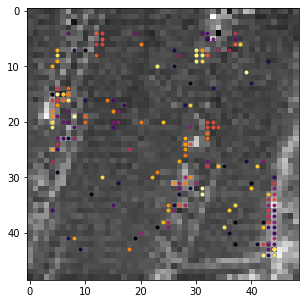

In [205]:
#exploration path

fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(5,5))
axes.imshow(image, cmap = 'gray')
colors = plt.get_cmap('inferno', env.num_measure)
for ind,point in enumerate(env.pos_X):
    
    axes.plot(point[1], point[0], marker='.', color = colors(ind))

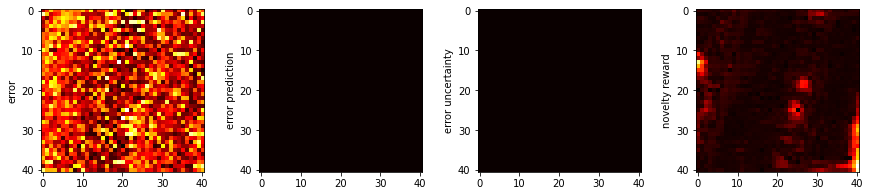

In [227]:
i = 0
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 3))

ax1.imshow(np.arctan(e_list[i]*100), cmap='hot', interpolation='nearest')
ax1.set_ylabel('error')

ax2.imshow(ep_list[i].reshape(image_size - 2*radius, image_size - 2*radius), cmap='hot', interpolation='nearest')
#ax2.plot(pos_X[ep_list[i].argmax()][1] - radius, pos_X[ep_list[i].argmax()][0] - radius, marker='.')
ax2.set_ylabel('error prediction')

ax3.imshow(np.exp(eu_list[i]).reshape(image_size - 2*radius, image_size - 2*radius), cmap='hot', interpolation='nearest')
ax3.set_ylabel('error uncertainty')

ax4.imshow(lat_reward_list[i], cmap='hot', interpolation='nearest')
ax4.set_ylabel("novelty reward")
plt.show()

In [28]:
#curiosity algorithm with MCD uncertainty classification

full_loss_list = []
full_max_loss_list = []

#full_loss_list = list(loss_list)
#full_max_loss_list = list(max_loss_list)

for k in range(num_trials):

    model = im2spec((image_patch, image_patch), y_dim, latent_dim = ldim_i).to(device)
    model_criterion = torch.nn.MSELoss()
    model_optimizer = optim.AdamW(model.parameters(), lr=0.001)
    model.eval()
    
    error_predictor = rewards_model(ldim_a).to(device)
    err_criterion = torch.nn.MSELoss()
    err_optimizer = optim.Adam(error_predictor.parameters(), lr=0.01)
    env = environment(image, spectra, start = start, image_patch = image_patch, image_size = image_size, y_dim = y_dim)
    featurizer = autoencoder
    im_feat = feature_extractor(featurizer, X)
    im_feat = im_feat.reshape([im_feat.shape[0], 1, im_feat.shape[1]]).to(device)
    action = start
    reward = [0]
    e_list = []
    max_e_list = []
    ep_list = []
    eu_list = []
    dist_reward_list = []
    lat_reward_list = []
    loss = []
    reward_list = []
    
    for i in range(initialize):
        #p = ((np.array(features.detach()) - centers[i])**2).sum(axis = 1).argmin()
        #action = pos_X[p]
        while env.measured[action[0], action[1]] == 1:
                action[0] = random.randint(radius, image_size - radius -1)
                action[1] = random.randint(radius, image_size - radius -1)
        
        env.step(action, False)

    for i in range(5*initialize):
        model_train(model, np.array(env.X), np.array(env.y), model_criterion, model_optimizer)

        y_pred = np.array(model(X_tensor.to(device)).cpu().detach())
        err = (((y_pred - y)**2).sum(axis = 2)/y_dim).reshape(image_size - 2*radius, image_size - 2*radius)
        #print(err.sum())
        loss.append(err.sum())



    pred = model(torch.tensor(np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).to(device)).cpu()
    gt = torch.tensor(np.array(env.y).reshape([len(env.y), 1, y_dim]))
    err_i = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
    for i in range(2):
        model_train(model, np.array(env.X), np.array(env.y), model_criterion, model_optimizer)

    pred = model(torch.tensor(np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).to(device)).cpu()
    err_f = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
    
    reward = (err_i + err_f).detach()

    reward_list.append(reward)
    
    #reward = (err_i - err_f).detach()
    
    #reward = np.exp((err_i + err_f).detach()) - 1 
    #reward = np.exp((err_i - err_f).detach()) - 1 

    reward = reward / reward.mean()
    
    for i in range(2*initialize):
        err_train(error_predictor, np.array(env.X), np.array(reward), err_criterion, err_optimizer, featurizer)

    

    err_mean = np.zeros([image_size - 2*radius, image_size - 2*radius])
    err_std = np.zeros([image_size - 2*radius, image_size - 2*radius])
    dist_reward = np.zeros([image_size, image_size])
    lat_reward = np.zeros([image_size - 2*radius, image_size - 2*radius])

    
    while env.num_measure < num_points:
        if random.randint(1, 10)//10:
            ep_list.append(err_mean)
            eu_list.append(err_std)
            dist_reward_list.append(dist_reward)
            lat_reward_list.append(lat_reward)
            while env.measured[action[0], action[1]] == 1:
                action[0] = random.randint(radius, image_size - radius -1)
                action[1] = random.randint(radius, image_size - radius -1)
        else:
            err_pred_list = []
            for i in range(500):
                err_pred_list.append(np.array(error_predictor(im_feat).reshape(X.shape[0]).detach().cpu()))
            err_pred_list = np.array(err_pred_list)
            err_mean = err_pred_list.mean(axis = 0)
            err_mean = err_mean/err_mean.mean()
            err_std = err_pred_list.std(axis = 0)
            err_std = err_std/err_std.mean()
            ep_list.append(err_mean)
            eu_list.append(err_std)
            for i in range(image_size):
                for j in range(image_size):
                    if [i, j] in env.pos_X:
                        dist_reward[i, j] = 0
                    else:
                        dist_reward[i, j] = (((np.array(env.pos_X) - np.array([i, j]))**2).sum(axis = 1)**-0.5).sum()**-1
            dist_reward = dist_reward/dist_reward.mean()
            dist_reward_list.append(dist_reward)
            
            lat_reward = np.zeros((image_size - 2*radius)**2)
            lat = feature_extractor(model, X).detach().numpy()
            lat_m = feature_extractor(model, np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).detach().numpy()
            for i in range((image_size - 2*radius)**2):
                lat_reward[i] = (((lat_m - lat[i])**2).sum(axis = 1)**-0.5).sum()**-1
            
            lat_reward = lat_reward.reshape(image_size - 2*radius, image_size - 2*radius)
            lat_reward = lat_reward/lat_reward.mean()
            lat_reward_list.append(lat_reward)
            
            model.train()
            
            y_pass = []
            for i in range(100):
                y_pass.append(np.array(model(X_tensor.to(device)).detach().cpu()))
            
            model.eval()
            
            y_pass = np.array(y_pass)
        
            y_unc = y_pass.std(axis = 0).mean(axis = 2)
            ep_list.append(y_unc)
            
            aq = err_mean.copy()*(1 + 2*np.exp(-lbda) - np.exp(-lbda * env.num_measure/num_points) - np.exp(lbda * (env.num_measure - num_points)/num_points)) + lat_reward.copy().reshape(-1) * np.exp(-lbda * env.num_measure/num_points) + y_unc.copy().reshape(-1) * np.exp(lbda * (env.num_measure - num_points)/num_points) # * dist_reward.copy().reshape(-1)
            
            while pos_X[aq.argmax()] in env.pos_X:
                aq[aq.argmax()] = aq.min()
            action_list = []
            for i in range(10):
                action_list.append([aq.argmax()//(image_size - 2*radius) +radius, aq.argmax()%(image_size - 2*radius) + radius])
                aq[aq.argmax()] = aq.min()
            
            action = random.choice(action_list)
        
        env.step(action, True)
        
        pred = model(torch.tensor(np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).to(device)).cpu()
        gt = torch.tensor(np.array(env.y).reshape([len(env.y), 1, y_dim]))
        err_i = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
        for i in range(2):
            model_train(model, np.array(env.X), np.array(env.y), model_criterion, model_optimizer)
        y_pred = np.array(model(X_tensor.to(device)).detach().cpu())
        err = (((y_pred - y)**2).sum(axis = 2)/y_dim).reshape(image_size - 2*radius, image_size - 2*radius)
        e_list.append(err)
        max_e_list.append(np.sort(e_list[-1].reshape(-1))[-10:].mean())
        print(err.sum())
        loss.append(err.sum())
        pred = model(torch.tensor(np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).to(device)).cpu()
        err_f = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
        
        reward = (err_i + err_f).detach()

        reward_list.append(reward)
        
        #reward = (err_i - err_f).detach()
        
        #reward = np.exp((err_i + err_f).detach()) - 1 
        #reward = np.exp((err_i - err_f).detach()) - 1 

        reward = reward/reward.mean()
    


        print(env.num_measure, end = "\r")

    # pred = model(torch.tensor(X))
    # gt = torch.tensor(y)
    # err_i = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
    # for i in range(2):
    #     model_train(model, X[:, 0], y[:, 0], model_criterion, model_optimizer)
    
    # pred = model(torch.tensor(X))
    # err_f = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
    # d_err = (err_i - err_f).detach().reshape(image_size - 2*radius, image_size - 2*radius)

    # model = im2spec((image_patch, image_patch), y_dim, 10)
    # model_criterion = torch.nn.MSELoss()
    # model_optimizer = optim.Adam(model.parameters(), lr=0.01)

    # loss = []
    # for i in range(200):
    #     model_train(model, np.array(env.X), np.array(env.y), model_criterion, model_optimizer)
    #     y_pred = np.array(model(torch.tensor(X)).detach())
    #     err = (((y_pred - y)**2).sum(axis = 2)/y_dim).reshape(image_size - 2*radius, image_size - 2*radius)
    #     loss.append(err.sum())

    #     print(str(i) + "         ", end = "\r")
    
    
    

    print(min(loss))
    print(min(max_e_list))
    
    full_loss_list.append(min(loss))
    full_max_loss_list.append(min(max_e_list))
    

73.87698
71.78702
69.83324
67.98761
66.19584
64.49792
62.844288
61.203053
59.59068
57.996513
56.47283
55.016594
53.603695
52.222866
51.06902
50.186867
49.514053
49.001045
48.545162
48.099194
47.583527
46.91977
46.0442
45.0178
44.15749
43.55603
43.523212
43.902946
43.935143
43.81672
43.304344
42.35857
41.136288
39.821117
39.02923
38.332283
37.666016
37.193314
36.803123
35.957645
35.0297
33.503468
31.879902
30.210564
29.323208
28.94149
28.88029
28.827227
28.975227
27.744942
26.159355
24.167648
22.951643
22.708603
22.724386
22.68461
22.652863
22.556278
22.06847
21.477182
20.800356
20.565449
20.809132
20.855518
20.762722
20.44709
20.038385
19.580471
19.311565
19.293446
19.023174
18.844707
18.712137
19.148935
19.619505
20.306643
21.820272
23.110317
24.099062
24.114166
24.156136
24.618042
24.857346
25.248543
25.786112
25.161741
24.512829
23.674177
23.32448
23.297781
22.834469
22.330608
22.287395
22.507692
22.961884
23.63318
23.502003
22.775541
22.760994
22.536257
22.560102
22.933681
23.89168

KeyboardInterrupt: 

In [209]:
#random sampling

rand_max_loss_list = []
rand_loss_list = []

#rand_loss_list = list(rand_loss_list)
#rand_max_loss_list = list(rand_max_loss_list)

for k in range(num_trials):

    model = im2spec((image_patch, image_patch), y_dim, ldim_i).to(device)
    model_criterion = torch.nn.MSELoss()
    model_optimizer = optim.AdamW(model.parameters(), lr=0.001)
    model.eval()
    
    error_predictor = rewards_model(ldim_a).to(device)
    err_criterion = torch.nn.MSELoss()
    err_optimizer = optim.Adam(error_predictor.parameters(), lr=0.01)
    env = environment(image, spectra, start = start, image_patch = image_patch, image_size = image_size, y_dim = y_dim)
    featurizer = autoencoder
    im_feat = feature_extractor(featurizer, X)
    im_feat = im_feat.reshape([im_feat.shape[0], 1, im_feat.shape[1]]).to(device)
    action = start
    reward = [0]
    e_list = []
    max_e_list = []
    ep_list = []
    eu_list = []
    dist_reward_list = []
    loss = []
    reward_list = []
    for i in range(initialize):
        #p = ((np.array(features.detach()) - centers[i])**2).sum(axis = 1).argmin()
        #action = pos_X[p]
        while env.measured[action[0], action[1]] == 1:
                action[0] = random.randint(radius, image_size - radius -1)
                action[1] = random.randint(radius, image_size - radius -1)
        
        env.step(action, False)

    for i in range(5*initialize):
        model_train(model, np.array(env.X), np.array(env.y), model_criterion, model_optimizer)

        y_pred = np.array(model(X_tensor.to(device)).cpu().detach())
        err = (((y_pred - y)**2).sum(axis = 2)/y_dim).reshape(image_size - 2*radius, image_size - 2*radius)
        print(err.sum())
        loss.append(err.sum())



    pred = model(torch.tensor(np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).to(device)).cpu()
    gt = torch.tensor(np.array(env.y).reshape([len(env.y), 1, y_dim]))
    err_i = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
    for i in range(2):
        model_train(model, np.array(env.X), np.array(env.y), model_criterion, model_optimizer)

    pred = model(torch.tensor(np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).to(device)).cpu()
    err_f = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
    
    reward = (err_i + err_f).detach()

    reward_list.append(reward)
    
    #reward = (err_i - err_f).detach()
    
    #reward = np.exp((err_i + err_f).detach()) - 1 
    #reward = np.exp((err_i - err_f).detach()) - 1 

    reward = reward / reward.mean()
    
    for i in range(2*initialize):
        err_train(error_predictor, np.array(env.X), np.array(reward), err_criterion, err_optimizer, featurizer)

    

    err_mean = np.zeros([image_size - 2*radius, image_size - 2*radius])
    err_std = np.zeros([image_size - 2*radius, image_size - 2*radius])
    dist_reward = np.zeros([image_size, image_size])


    
    while env.num_measure < num_points:

        
        ep_list.append(err_mean)
        eu_list.append(err_std)
        dist_reward_list.append(dist_reward)
        while env.measured[action[0], action[1]] == 1:
            action[0] = random.randint(radius, image_size - radius -1)
            action[1] = random.randint(radius, image_size - radius -1)
       
        
        env.step(action, True)
        
        pred = model(torch.tensor(np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).to(device)).cpu()
        gt = torch.tensor(np.array(env.y).reshape([len(env.y), 1, y_dim]))
        err_i = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
        for i in range(2):
            model_train(model, np.array(env.X), np.array(env.y), model_criterion, model_optimizer)
        y_pred = np.array(model(X_tensor.to(device)).detach().cpu())
        err = (((y_pred - y)**2).sum(axis = 2)/y_dim).reshape(image_size - 2*radius, image_size - 2*radius)
        e_list.append(err)
        max_e_list.append(np.sort(e_list[-1].reshape(-1))[-10:].mean())
        print(err.sum())
        loss.append(err.sum())
        pred = model(torch.tensor(np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).to(device)).cpu()
        err_f = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
        
        reward = (err_i + err_f).detach()

        reward_list.append(reward)
        
        #reward = (err_i - err_f).detach()
        
        #reward = np.exp((err_i + err_f).detach()) - 1 
        #reward = np.exp((err_i - err_f).detach()) - 1 

        reward = reward/reward.mean()
    


        print(env.num_measure, end = "\r")

    # pred = model(torch.tensor(X))
    # gt = torch.tensor(y)
    # err_i = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
    # for i in range(2):
    #     model_train(model, X[:, 0], y[:, 0], model_criterion, model_optimizer)
    
    # pred = model(torch.tensor(X))
    # err_f = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
    # d_err = (err_i - err_f).detach().reshape(image_size - 2*radius, image_size - 2*radius)

    # model = im2spec((image_patch, image_patch), y_dim, 10)
    # model_criterion = torch.nn.MSELoss()
    # model_optimizer = optim.Adam(model.parameters(), lr=0.01)

    # loss = []
    # for i in range(200):
    #     model_train(model, np.array(env.X), np.array(env.y), model_criterion, model_optimizer)
    #     y_pred = np.array(model(torch.tensor(X)).detach())
    #     err = (((y_pred - y)**2).sum(axis = 2)/y_dim).reshape(image_size - 2*radius, image_size - 2*radius)
    #     loss.append(err.sum())

    #     print(str(i) + "         ", end = "\r")

    
    
    
    print(min(loss))
    print(min(max_e_list))
    
    rand_loss_list.append(min(loss))
    rand_max_loss_list.append(min(max_e_list))
    

322.67798
317.9917
313.39
308.80402
304.21744
299.5063
294.82706
289.93457
284.57794
278.59024
272.0522
264.0485
254.35248
241.92029
226.57959
208.5239
189.37369
171.95523
157.4435
146.08218
137.19704
130.15947
122.83676
114.46005
104.94971
93.51955
82.170334
72.29548
64.79748
59.638344
56.653748
54.66822
52.768642
50.389313
46.640648
42.279083
37.859703
33.92784
31.58878
30.471966
29.929848
29.21888
28.347511
27.011375
25.285051
23.500286
22.302746
21.421886
20.869827
20.77533
20.848331
20.507833
19.771023
18.983994
18.421783
17.838003
17.122295
16.623293
16.440823
16.172396
16.115053
16.149715
15.870464
15.504709
14.867346
14.304408
14.106866
14.027584
14.147278
14.34031
14.440241
14.211636
13.946472
13.861084
13.864895
13.88405
13.887346
13.865269
13.820541
13.757166
13.7294035
13.7327795
13.729066
13.707164
13.685258
13.671602
13.668999
13.740828
13.885632
13.943287
13.860292
13.770533
13.762214
13.8298
13.919455
14.022817
14.051834
13.860764
13.675066
13.6027775
13.612266
13.66061

23.159592
23.08842
22.516365
21.457098
20.015308
18.560265
17.592342
17.232096
17.37874
17.538279
17.41119
16.77405
15.887646
15.217763
14.781125
14.52182
14.383562
14.376518
14.4429035
14.425728
14.246272
14.063691
13.959478
13.9135275
13.881079
13.875196
13.912933
13.907543
13.830617
13.764101
13.75161
13.756616
13.732401
13.72115
13.718645
13.703398
13.730735
13.824621
13.967832
14.009082
13.922401
13.798101
13.735289
13.761272
13.881395
14.121124
14.472223
14.432161
14.219039
14.072666
13.977784
13.96975
13.989735
13.911554
13.888113
13.971079
14.110107
14.100003
14.091658
14.103803
14.050152
13.931912
13.867865
13.771212
13.700675
13.669701
13.679333
13.770945
13.90502
13.922487
13.744079
13.652093
13.71774
13.708535
13.642868
13.713285
13.923149
14.019688
13.898841
13.746174
13.761622
13.788382
13.985139
14.322541
14.498047
14.525518
14.222482
14.170361
14.081097
14.015269
14.11406
14.404247
14.6046295
14.341574
14.122096
13.997141
13.957618
13.935604
13.919824
14.0131855
14.0427

13.127394
13.514992
13.064476
13.09627
13.136105
12.841878
13.136209
12.84646
12.849489
12.914415
12.844403
13.220772
12.729069
12.95612
13.020411
12.839018
13.2024
13.153916
12.851092
12.672537
12.798639
12.997831
12.890589
13.269096
12.849812
13.346326
12.764673
12.932535
12.747953
13.168239
13.081694
12.730602
12.801517
12.432716
12.42992
12.529598
12.483263
12.5845785
12.639708
12.764397
12.73928
12.881749
12.774533
12.897091
13.029913
12.878096
13.19545
12.919445
12.774097
12.839781
12.849293
12.886644
13.415498
13.742336
13.446557
13.000214
12.8289585
12.662926
12.689833
12.672898
13.128693
12.945784
12.997286
13.429014
13.093984
13.158351
14.612599
13.08198
13.390818
13.430949
12.887502
13.123173
12.657534
12.605215
12.789166
12.649862
12.623981
12.809306
12.635269
12.721341
13.117852
13.093704
12.60895
12.991015
13.229054
12.942301
12.42992
0.08361464
289.2065
283.9187
278.64185
273.32886
267.8753
262.23956
256.54312
250.46426
243.43652
235.32976
225.61967
214.252
199.92331
181

13.566187
13.601921
13.569432
13.48503
13.459738
13.467793
13.543703
13.860877
13.979303
14.007
13.820297
13.727589
13.790262
13.749743
13.828059
13.9424515
13.946276
14.1785755
14.094515
13.727464
13.559254
13.515738
13.576989
13.681936
13.696333
13.627508
13.521158
13.515345
13.56176
13.530359
13.660288
13.848658
13.73356
13.586072
13.51973
13.510256
13.515408
13.799119
14.516815
14.693053
14.150093
13.682058
13.520133
13.490475
13.552088
13.640755
13.683266
13.734705
13.643092
13.646372
13.657042
14.332774
13.866156
13.524173
13.683348
13.547306
13.519701
13.493904
13.499119
13.477839
13.479098
13.558729
13.52331
13.729045
13.861608
13.722969
13.992672
14.058027
14.09827
14.183557
14.039143
13.521442
13.49065
14.355429
13.654211
13.4825325
13.904808
13.663439
13.56582
13.969614
14.052229
13.533705
13.774647
14.509066
13.715517
13.613112
13.940384
13.841399
13.466748
13.42865
13.665932
13.640303
13.414381
13.433336
13.661708
13.373516
13.253624
13.497436
13.64118
13.345079
13.538028


14.647751
14.380043
14.092522
14.557939
14.192173
14.515955
14.864614
13.691699
13.746816
13.975673
13.794775
13.860155
14.170094
14.022911
14.043211
13.979849
13.619974
13.589735
13.466848
13.532305
13.706676
13.874325
14.238339
13.801435
14.028319
13.725893
13.68358
13.497099
13.509299
13.621441
13.586462
13.635921
13.716569
13.655956
13.698151
13.50882
13.633108
13.618162
13.466848
0.07733899
342.5374
337.88037
333.14395
328.333
323.49408
318.5105
312.59576
306.16425
298.56683
289.51312
277.3009
260.0586
239.50693
218.4963
200.77101
188.23218
180.0774
175.3726
172.82709
170.90378
168.07567
163.13022
155.61661
145.67036
133.70374
120.74858
107.87593
96.96976
88.544815
82.8803
79.71132
78.344315
77.71182
77.036316
75.006836
71.456924
65.97768
59.4274
53.20807
47.494995
43.246403
40.2834
38.827274
38.438457
38.19046
37.743107
36.461044
34.33839
31.792337
29.29271
26.915287
25.019346
23.613297
22.78616
22.636694
22.583303
22.477873
22.180656
21.92032
21.383678
20.819557
20.151306
19.354

13.838407
14.117178
14.2511015
14.06797
13.93788
13.875996
13.676847
13.676352
13.859715
13.638798
13.795557
13.931341
13.851952
13.893398
14.118459
13.972051
14.013381
14.0404415
14.105631
14.442526
14.332247
14.173134
14.704608
14.688427
14.214061
14.338948
14.813513
14.376179
14.532341
14.691896
14.063347
13.955669
14.194457
14.068059
13.886709
14.353479
14.479954
14.171646
14.418243
14.344921
14.018414
14.126111
14.270081
13.785694
13.9286175
14.337317
13.911698
14.050457
14.518363
13.795721
13.654171
13.722221
13.702939
13.595542
13.765572
13.834251
13.683588
13.798283
13.85195
13.588207
13.587759
13.656249
13.523101
13.531361
13.816985
13.717678
13.796094
14.070813
13.748
13.601788
13.511827
13.486397
13.402992
13.45641
13.401845
13.393586
13.389615
13.322966
13.362206
13.284075
13.260714
13.372097
13.269984
13.388344
13.568787
13.25966
13.217883
13.251051
13.211479
13.331399
13.605846
13.280781
13.251816
13.274519
13.252253
13.223237
13.220476
13.211668
13.267422
13.166352
13.16

311.75818
305.1391
297.79547
289.39575
279.38672
266.0846
249.0398
228.69003
206.33871
186.27466
171.57056
161.21092
154.01117
149.08038
145.59146
141.49142
135.57645
126.96483
115.49259
102.00115
88.484116
76.48861
67.24781
61.13413
57.94624
56.522358
55.56941
54.019238
50.754757
46.527584
41.837925
37.156136
33.545822
31.218681
29.744507
29.521084
29.753242
30.005625
29.480888
27.769001
25.351341
22.398342
20.131855
18.59861
18.314346
18.568718
19.085548
19.76816
20.037903
19.224758
18.065056
17.136698
16.387115
15.849324
15.618666
15.441454
15.526438
15.965267
16.267984
16.056896
15.6343975
15.133721
14.682617
14.437712
14.361652
14.338461
14.371419
14.460688
14.494805
14.448455
14.327549
14.258076
14.206681
14.228905
14.227997
14.209857
14.188614
14.215086
14.216091
14.208937
14.194149
14.21628
14.288164
14.28751
14.280031
14.244799
14.20801
14.210737
14.170005
14.133909
14.132116
14.168366
14.261596
14.398096
14.600504
14.468229
14.267164
14.16354
14.160969
14.185276
14.412837
14.

14.382407
14.821875
15.059576
15.298398
15.275819
15.133259
15.053086
14.709319
14.48854
14.552523
14.731396
14.845408
14.812178
15.300833
15.413769
14.595309
14.037079
13.820454
13.865026
13.956991
13.982223
14.0875435
14.4761
14.758637
14.716969
14.840483
14.702636
14.296391
14.242446
14.272506
14.568247
14.482252
14.748802
14.985932
14.577087
14.094948
14.196079
14.038086
14.0714655
14.191189
14.767771
14.800233
14.476408
14.098631
13.898616
13.933332
13.872774
14.093038
14.3588085
14.369326
14.272734
14.2333
14.420621
14.529945
14.305603
14.067869
14.180038
14.212577
14.510429
15.019571
15.405742
14.88229
14.769846
15.122794
14.623266
14.491151
14.446877
14.249531
14.028163
14.019059
14.065873
14.300659
14.5525465
14.582538
14.743187
15.09994
14.541125
13.82239
13.749101
13.679985
13.7420845
14.008941
14.217164
13.984719
14.211208
14.557908
14.837859
14.489616
14.355559
14.588014
15.136075
14.828043
14.420616
14.750126
15.185982
14.476898
14.305624
14.713766
14.747308
14.408661
14.

26.124765
25.67781
26.159239
26.686089
26.855461
26.455803
25.157032
23.299105
21.492264
20.031359
19.366486
19.53976
20.235737
20.851795
21.269932
21.346958
20.414259
19.528202
18.94807
18.732721
18.497242
18.52923
18.234741
18.37009
18.745846
18.449371
17.911728
17.046434
16.535355
16.32052
16.14759
16.029188
15.903334
15.795219
15.697222
15.67626
15.665579
15.55509
15.513947
15.528797
15.525175
15.561274
15.585205
15.528019
15.616867
15.5888195
15.578963
15.597339
15.615731
15.586714
15.533459
15.501955
15.537954
15.678992
15.855423
15.809059
15.606811
15.469414
15.424486
15.502459
15.7930565
16.122595
16.243006
15.961554
15.588019
15.410229
15.387722
15.394213
15.429796
15.608943
15.857352
15.890118
15.860854
15.730917
15.599536
15.324228
15.264148
15.209368
15.238146
15.474227
15.593678
15.631776
15.507969
15.32226
15.291641
15.365841
15.455335
15.433304
15.285658
15.149804
15.149349
15.114312
15.1107235
15.115195
15.108782
15.095255
15.089381
15.135134
15.119234
15.050941
14.9502

14.961203
14.913803
14.890278
14.87752
14.880228
14.88985
14.905246
14.90602
14.885068
14.876833
14.887228
14.942187
15.029659
15.129499
15.131504
15.017474
14.949747
14.92631
15.066087
15.189076
15.133507
15.017323
14.976883
14.968975
14.987919
14.965218
14.9348955
14.920623
14.899021
14.944543
15.102601
15.073153
14.95051
14.925627
14.96516
15.024875
15.037037
15.040596
15.344343
15.515633
15.358668
15.139378
15.039568
15.039842
15.029834
15.000935
15.028017
15.149205
15.320543
15.457096
15.381319
15.171869
14.95416
14.893609
14.888107
14.929701
14.916698
14.949389
14.934534
14.968979
14.841624
14.827218
14.855722
15.064133
15.371652
14.985051
14.725612
15.407785
15.568333
14.63261
14.512648
14.970216
14.774477
14.18503
14.132374
14.165539
14.146641
14.070118
14.121704
14.102017
14.213505
14.142324
14.1685295
14.44573
14.371345
14.25947
14.301415
14.330522
14.270873
14.208834
14.124558
14.497122
14.341709
14.077339
14.04788
14.128715
13.98948
13.902364
13.944132
13.914216
13.909122
1

In [210]:
loss_list = np.array(loss_list)
loss_list.mean(), loss_list.std()

(12.591808, 0.3071909)

In [211]:
max_loss_list = np.array(max_loss_list)
max_loss_list.mean(), max_loss_list.std()

(0.07776071, 0.0056651756)

In [ ]:
full_loss_list = np.array(full_loss_list)
full_loss_list.mean(), full_loss_list.std()

In [ ]:
full_max_loss_list = np.array(full_max_loss_list)
full_max_loss_list.mean(), full_max_loss_list.std()

In [212]:
rand_loss_list = np.array(rand_loss_list)
rand_loss_list.mean(), rand_loss_list.std()

(12.96281, 0.37015492)

In [213]:
rand_max_loss_list = np.array(rand_max_loss_list)
rand_max_loss_list.mean(), rand_max_loss_list.std()

(0.08143723, 0.0063545764)

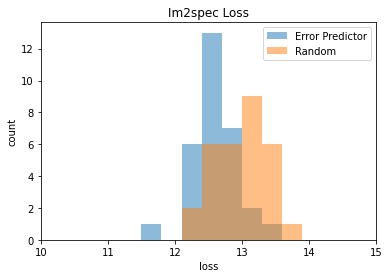

In [229]:
#histograms

bins = np.arange(10, 15, 0.3)

plt.xlim([10, 15])

plt.hist(loss_list, bins=bins, alpha=0.5, label = "Curiosity")
plt.hist(rand_loss_list, bins=bins, alpha=0.5, label = "Random")
plt.hist(full_loss_list, bins=bins, alpha=0.5, label = "Curiosity with MCD")



plt.xlabel('loss')
plt.ylabel('count')
plt.title("Im2spec Loss")

plt.legend()

plt.show()

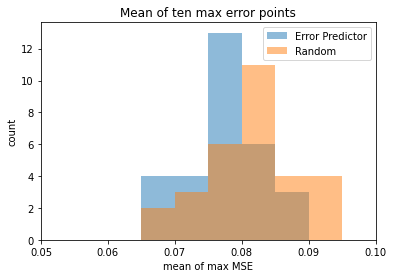

In [234]:
bins = np.arange(0.05, 0.10, 0.005)

plt.xlim([0.05, 0.10])

plt.hist(max_loss_list, bins=bins, alpha=0.5, label = "Curiosity")
plt.hist(rand_max_loss_list, bins=bins, alpha=0.5, label = "Random")
plt.hist(full_max_loss_list, bins=bins, alpha=0.5, label = "Curiosity with MCD")


plt.xlabel('mean of max MSE')
plt.ylabel('count')
plt.title('Mean of ten max error points')

plt.legend()

plt.show()